In [1]:
!pip install transformers
!pip install pandas
!pip install tensorflow_hub
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 94.4 MB/s eta 0:00:00


In [2]:
from scipy.stats import pearsonr
from transformers import BertTokenizer, TFBertModel
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn.metrics

# **Read in data and preprocess**

In [3]:
preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1')

In [4]:
df = pd.read_table("lcp_multi_train.tsv", keep_default_na=False, quoting=3)

In [ ]:
# random.seed(0)
# random_train_indexes = random.sample(range(len(df)), 4000)

In [5]:
sentence_array = []
token_array = []
output_array = []

for i in range(len(df)):
  sentence_array.append(df.iloc[i]['sentence'])
  token_array.append(df.iloc[i]['token'])
  output_array.append(df.iloc[i]['complexity'])

# for i in random_train_indexes:
#   sentence_array.append(df.iloc[i]['sentence'])
#   token_array.append(df.iloc[i]['token'])
#   output_array.append(df.iloc[i]['complexity'])

preprocessed_sentence_array = preprocess.tokenize(sentence_array)
preprocessed_token_array = preprocess.tokenize(token_array)
encoder_inputs = preprocess.bert_pack_inputs([preprocessed_sentence_array, preprocessed_token_array])
outputs_as_tensor = tf.convert_to_tensor(output_array)

Graphic of encoder input. Yellow = sentence content, Purple = pad characters

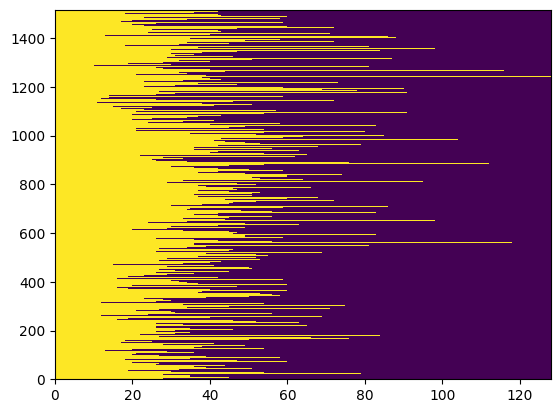

In [6]:
plt.pcolormesh(encoder_inputs['input_mask'])

Two strings were "packed" into a single input and padded up to a length of 128. First purple region on left = full sentences
Yellow region = target token multi word expression to predict complexity on
Second purple region on right = pad characters

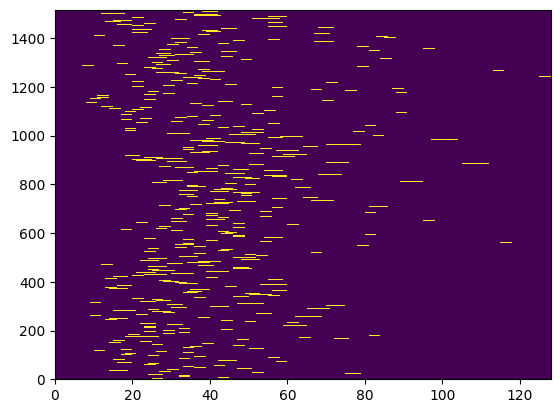

In [7]:
plt.pcolormesh(encoder_inputs['input_type_ids'])

In [8]:
test_df = pd.read_table("lcp_multi_test.tsv", keep_default_na=False, quoting=3)
sentence_array_test = []
token_array_test = []
output_array_test = []

for i in range(len(test_df)):
  sentence_array_test.append(test_df.iloc[i]['sentence'])
  token_array_test.append(test_df.iloc[i]['token'])
  output_array_test.append(test_df.iloc[i]['complexity'])

preprocessed_sentence_array_test = preprocess.tokenize(sentence_array_test)
preprocessed_token_array_test = preprocess.tokenize(token_array_test)
encoder_inputs_test = preprocess.bert_pack_inputs([preprocessed_sentence_array_test, preprocessed_token_array_test])
outputs_as_tensor_test = tf.convert_to_tensor(output_array_test)

# **Pre-trained BERT**

In [9]:
def build_bert_regression_model():

  class BERT_Regression(tf.keras.Model):
    def __init__(self):
      super(BERT_Regression, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.1)
      self.dense = tf.keras.layers.Dense(1, activation='sigmoid', name="output")

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = BERT_Regression()
  return model

In [44]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
bert_model = build_bert_regression_model()
bert_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.MeanSquaredError()]
)

In [45]:
history = bert_model.fit(encoder_inputs, outputs_as_tensor, batch_size=32, epochs=10, callbacks=[callback], validation_split=0.1)

Epoch 1/10
43/43 [==============================] - 77s 844ms/step - loss: 0.0234 - mean_squared_error: 0.0234 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 2/10
43/43 [==============================] - 35s 813ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0155 - val_mean_squared_error: 0.0155
Epoch 3/10
43/43 [==============================] - 35s 814ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0155 - val_mean_squared_error: 0.0155
Epoch 4/10
43/43 [==============================] - 35s 816ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 5/10
43/43 [==============================] - 35s 815ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0173 - val_mean_squared_error: 0.0173
Epoch 6/10
43/43 [==============================] - 35s 815ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 7/10
43/43 [====

In [49]:
bert_model.summary()

Model: "prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_7 (KerasLayer)  multiple                  109482241 
                                                                 
 dropout_7 (Dropout)         multiple                  0         
                                                                 
 output (Dense)              multiple                  769       
                                                                 
Total params: 109,483,010
Trainable params: 109,483,009
Non-trainable params: 1
_________________________________________________________________


In [ ]:
# Save the weights
bert_model.save_weights('./checkpoints/bert')

In [46]:
out_test_data_bert = bert_model.predict(encoder_inputs_test)

6/6 [==============================] - 2s 281ms/step


In [47]:
pearsonr(np.reshape(out_test_data_bert, len(out_test_data_bert)), output_array_test)

PearsonRResult(statistic=0.8002015164842359, pvalue=2.8503865420622434e-42)

In [48]:
sklearn.metrics.r2_score(output_array_test, np.reshape(out_test_data_bert, len(out_test_data_bert)))

0.5764409857200905

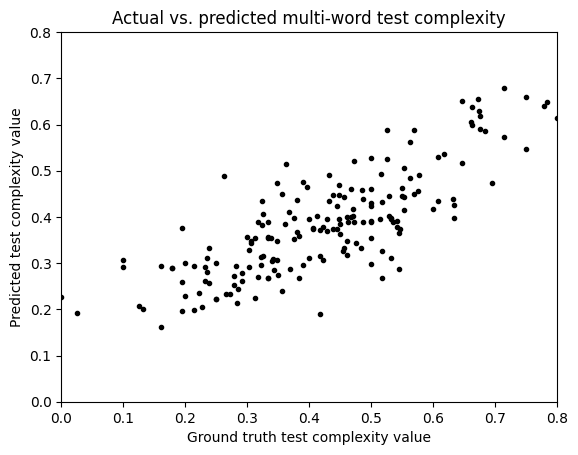

In [62]:
plt.plot(output_array_test, np.reshape(out_test_data_bert, len(out_test_data_bert)), 'k.')
plt.xlabel("Ground truth test complexity value")
plt.ylabel("Predicted test complexity value")
plt.title("Actual vs. predicted multi-word test complexity")
plt.xlim([0,0.8])
plt.ylim([0,0.8])
plt.show()

**Test data and prediction analysis**

Test mean, median, variance follow similar patterns as train data

In [51]:
bible_test_idx = np.where(test_df['corpus']=='bible')
biomed_test_idx = np.where(test_df['corpus']=='biomed')
europarl_test_idx = np.where(test_df['corpus']=='europarl')

In [52]:
print('Bible test points mean: ' + str(np.mean(np.array(output_array_test)[bible_test_idx])))
print('Biomed test points mean: ' + str(np.mean(np.array(output_array_test)[biomed_test_idx])))
print('Europarl test points mean: ' + str(np.mean(np.array(output_array_test)[europarl_test_idx])))
print('Bible test points variance: ' + str(np.var(np.array(output_array_test)[bible_test_idx])))
print('Biomed test points variance: ' + str(np.var(np.array(output_array_test)[biomed_test_idx])))
print('Europarl test points variance: ' + str(np.var(np.array(output_array_test)[europarl_test_idx])))



Bible test points mean: 0.37699347045674086
Biomed test points mean: 0.4830227348177068
Europarl test points mean: 0.4188264147945801
Bible test points variance: 0.02299753542058521
Biomed test points variance: 0.038291929220360614
Europarl test points variance: 0.008649803287904012


Pearson correlation and R2 separated by corpus. Best predictive capability on biomed sentences. Much lower predictive capability on europarl.

In [53]:
print(pearsonr(np.reshape(out_test_data_bert[bible_test_idx], len(out_test_data_bert[bible_test_idx])), np.array(output_array_test)[bible_test_idx]))
print(pearsonr(np.reshape(out_test_data_bert[biomed_test_idx], len(out_test_data_bert[biomed_test_idx])), np.array(output_array_test)[biomed_test_idx]))
print(pearsonr(np.reshape(out_test_data_bert[europarl_test_idx], len(out_test_data_bert[europarl_test_idx])), np.array(output_array_test)[europarl_test_idx]))

PearsonRResult(statistic=0.7624204406395751, pvalue=1.0273847623060162e-13)
PearsonRResult(statistic=0.8779476950475322, pvalue=6.109482681749829e-18)
PearsonRResult(statistic=0.5445316672561746, pvalue=2.7441456942144345e-06)


In [54]:
print(sklearn.metrics.r2_score(np.array(output_array_test)[bible_test_idx], np.reshape(out_test_data_bert[bible_test_idx], len(out_test_data_bert[bible_test_idx]))))
print(sklearn.metrics.r2_score(np.array(output_array_test)[biomed_test_idx], np.reshape(out_test_data_bert[biomed_test_idx], len(out_test_data_bert[biomed_test_idx]))))
print(sklearn.metrics.r2_score(np.array(output_array_test)[europarl_test_idx], np.reshape(out_test_data_bert[europarl_test_idx], len(out_test_data_bert[europarl_test_idx]))))

0.5250508612217144
0.7305223270022247
-0.09087582662446692


Predicted values on average were between 1 and 2 points off from actuals on 5-point complexity scale (0.25 and 0.5 on 0 to 1 scale) 

In [55]:
bible_avg_abs_diff = np.mean(np.abs(np.reshape(out_test_data_bert[bible_test_idx], len(out_test_data_bert[bible_test_idx])), np.array(output_array_test)[bible_test_idx]))
biomed_avg_abs_diff = np.mean(np.abs(np.reshape(out_test_data_bert[biomed_test_idx], len(out_test_data_bert[biomed_test_idx])), np.array(output_array_test)[biomed_test_idx]))
europarl_avg_abs_diff = np.mean(np.abs(np.reshape(out_test_data_bert[europarl_test_idx], len(out_test_data_bert[europarl_test_idx])), np.array(output_array_test)[europarl_test_idx]))

print("Average absolute difference, predicted vs. actual:\n  Bible:  " + 
      str(bible_avg_abs_diff) + "\n  Biomed:  " + 
      str(biomed_avg_abs_diff) + "\n  Europarl:  " +
      str(europarl_avg_abs_diff))

Average absolute difference, predicted vs. actual:
  Bible:  0.34800317228743527
  Biomed:  0.4567010011875404
  Europarl:  0.36326860189437865


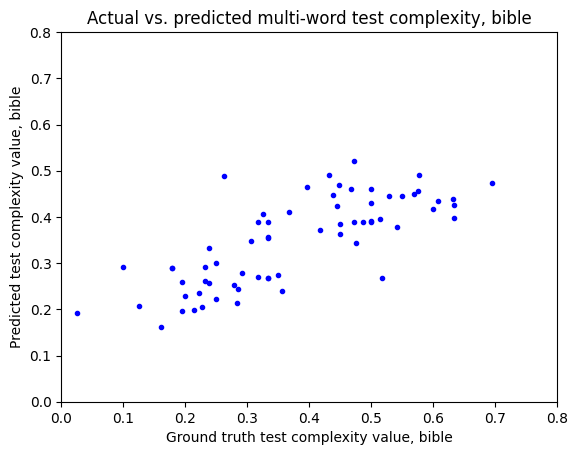

In [61]:
plt.plot(np.array(output_array_test)[bible_test_idx], np.reshape(out_test_data_bert[bible_test_idx], len(out_test_data_bert[bible_test_idx])), 'b.')
plt.xlabel("Ground truth test complexity value, bible")
plt.ylabel("Predicted test complexity value, bible")
plt.title("Actual vs. predicted multi-word test complexity, bible")
plt.xlim([0,0.8])
plt.ylim([0,0.8])
plt.show()


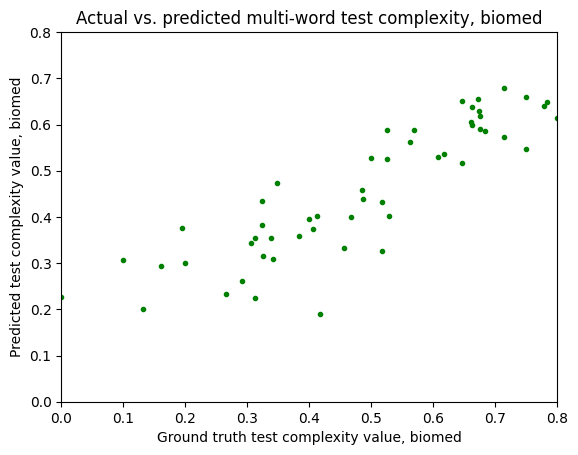

In [60]:
plt.plot(np.array(output_array_test)[biomed_test_idx], np.reshape(out_test_data_bert[biomed_test_idx], len(out_test_data_bert[biomed_test_idx])), 'g.')
plt.xlabel("Ground truth test complexity value, biomed")
plt.ylabel("Predicted test complexity value, biomed")
plt.title("Actual vs. predicted multi-word test complexity, biomed")
plt.xlim([0,0.8])
plt.ylim([0,0.8])
plt.show()


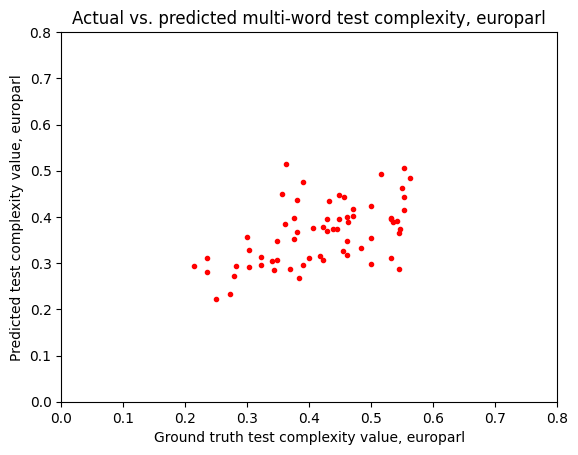

In [59]:
plt.plot(np.array(output_array_test)[europarl_test_idx], np.reshape(out_test_data_bert[europarl_test_idx], len(out_test_data_bert[europarl_test_idx])), 'r.')
plt.xlabel("Ground truth test complexity value, europarl")
plt.ylabel("Predicted test complexity value, europarl")
plt.title("Actual vs. predicted multi-word test complexity, europarl")
plt.xlim([0,0.8])
plt.ylim([0,0.8])

plt.show()

# **BERT Expert pretrained on Medical corpus**




In [63]:
def build_bert_medical_model():

  class BERT_Medical_Regression(tf.keras.Model):
    def __init__(self):
      super(BERT_Medical_Regression, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer("https://tfhub.dev/google/experts/bert/pubmed/2", trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.1)
      self.dense = tf.keras.layers.Dense(1, activation='sigmoid', name="output")

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = BERT_Medical_Regression()
  return model

In [113]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
bert_medical_model = build_bert_medical_model()
bert_medical_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.MeanSquaredError()],
)

In [114]:
bert_medical_model_history = bert_medical_model.fit(encoder_inputs, outputs_as_tensor, batch_size=32, epochs=10, callbacks=[callback], validation_split=0.1)

Epoch 1/10
43/43 [==============================] - 76s 833ms/step - loss: 0.0464 - mean_squared_error: 0.0464 - val_loss: 0.0431 - val_mean_squared_error: 0.0431
Epoch 2/10
43/43 [==============================] - 35s 818ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 3/10
43/43 [==============================] - 35s 818ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - val_loss: 0.0294 - val_mean_squared_error: 0.0294
Epoch 4/10
43/43 [==============================] - 36s 831ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 5/10
43/43 [==============================] - 36s 841ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0418 - val_mean_squared_error: 0.0418
Epoch 6/10
43/43 [==============================] - 36s 835ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0294 - val_mean_squared_error: 0.0294
Epoch 7/10
43/43 [====

In [66]:
bert_medical_model.summary()

Model: "prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_8 (KerasLayer)  multiple                  109482241 
                                                                 
 dropout_8 (Dropout)         multiple                  0         
                                                                 
 output (Dense)              multiple                  769       
                                                                 
Total params: 109,483,010
Trainable params: 109,483,009
Non-trainable params: 1
_________________________________________________________________


In [115]:
out_test_data_bert_medical = bert_medical_model.predict(encoder_inputs_test)

6/6 [==============================] - 2s 275ms/step


In [116]:
pearsonr(np.reshape(out_test_data_bert_medical, len(out_test_data_bert_medical)), output_array_test)

PearsonRResult(statistic=0.7539984820935307, pvalue=4.7223788643135783e-35)

In [117]:
sklearn.metrics.r2_score(output_array_test, np.reshape(out_test_data_bert_medical, len(out_test_data_bert_medical)))

0.40295397968680713

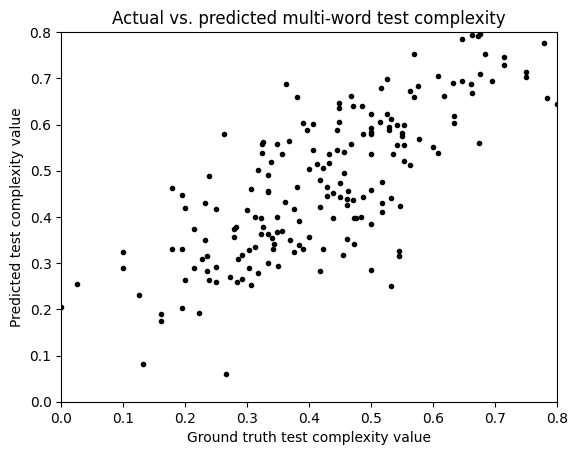

In [118]:
plt.plot(output_array_test, np.reshape(out_test_data_bert_medical, len(out_test_data_bert_medical)), 'k.')
plt.xlabel("Ground truth test complexity value")
plt.ylabel("Predicted test complexity value")
plt.title("Actual vs. predicted multi-word test complexity")
plt.xlim([0,0.8])
plt.ylim([0,0.8])
plt.show()

In [119]:
print(pearsonr(np.reshape(out_test_data_bert_medical[bible_test_idx], len(out_test_data_bert_medical[bible_test_idx])), np.array(output_array_test)[bible_test_idx]))
print(pearsonr(np.reshape(out_test_data_bert_medical[biomed_test_idx], len(out_test_data_bert_medical[biomed_test_idx])), np.array(output_array_test)[biomed_test_idx]))
print(pearsonr(np.reshape(out_test_data_bert_medical[europarl_test_idx], len(out_test_data_bert_medical[europarl_test_idx])), np.array(output_array_test)[europarl_test_idx]))

PearsonRResult(statistic=0.7836127188989079, pvalue=7.379733204035438e-15)
PearsonRResult(statistic=0.8435729629979682, pvalue=2.2178456768094e-15)
PearsonRResult(statistic=0.4135475469059323, pvalue=0.0006168554414673765)


In [120]:
print(sklearn.metrics.r2_score(np.array(output_array_test)[bible_test_idx], np.reshape(out_test_data_bert_medical[bible_test_idx], len(out_test_data_bert_medical[bible_test_idx]))))
print(sklearn.metrics.r2_score(np.array(output_array_test)[biomed_test_idx], np.reshape(out_test_data_bert_medical[biomed_test_idx], len(out_test_data_bert_medical[biomed_test_idx]))))
print(sklearn.metrics.r2_score(np.array(output_array_test)[europarl_test_idx], np.reshape(out_test_data_bert_medical[europarl_test_idx], len(out_test_data_bert_medical[europarl_test_idx]))))

0.34633581034278715
0.606213001205937
-0.5301092801150342


# **Electra**

In [86]:
def build_electra_model():

  class Electra_Regression(tf.keras.Model):
    def __init__(self):
      super(Electra_Regression, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer("https://tfhub.dev/google/electra_base/2", trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.1)
      self.dense = tf.keras.layers.Dense(1, activation='sigmoid', name="output")

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = Electra_Regression()
  return model

In [87]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
electra_model = build_electra_model()
electra_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.MeanSquaredError()],
)

In [88]:
electra_model_history = electra_model.fit(encoder_inputs, outputs_as_tensor, batch_size=32, epochs=10, callbacks=[callback], validation_split=0.1)

Epoch 1/10
43/43 [==============================] - 76s 822ms/step - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0254 - val_mean_squared_error: 0.0254
Epoch 2/10
43/43 [==============================] - 35s 813ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0219 - val_mean_squared_error: 0.0219
Epoch 3/10
43/43 [==============================] - 35s 812ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0232 - val_mean_squared_error: 0.0232
Epoch 4/10
43/43 [==============================] - 35s 824ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0144 - val_mean_squared_error: 0.0144
Epoch 5/10
43/43 [==============================] - 35s 826ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 6/10
43/43 [==============================] - 36s 828ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0164 - val_mean_squared_error: 0.0164
Epoch 7/10
43/43 [====

In [89]:
electra_model.summary()

Model: "prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_12 (KerasLayer)  multiple                 109482241 
                                                                 
 dropout_12 (Dropout)        multiple                  0         
                                                                 
 output (Dense)              multiple                  769       
                                                                 
Total params: 109,483,010
Trainable params: 109,483,009
Non-trainable params: 1
_________________________________________________________________


In [90]:
out_test_data_electra = electra_model.predict(encoder_inputs_test)

6/6 [==============================] - 2s 268ms/step


In [91]:
pearsonr(np.reshape(out_test_data_electra, len(out_test_data_electra)), output_array_test)

PearsonRResult(statistic=0.7701580386749729, pvalue=2.199314847724513e-37)

In [92]:
sklearn.metrics.r2_score(output_array_test, np.reshape(out_test_data_bert_medical, len(out_test_data_bert_medical)))

0.5249482072872338

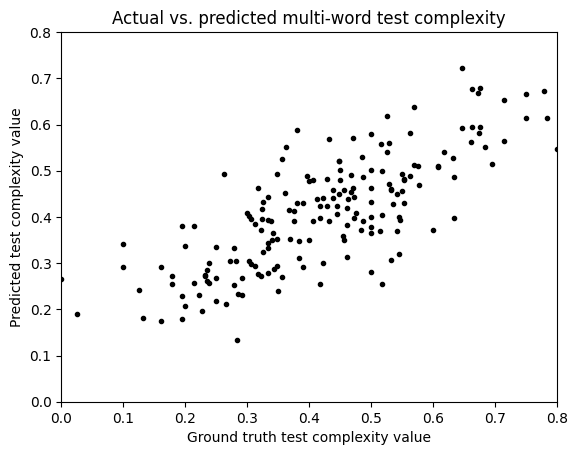

In [93]:
plt.plot(output_array_test, np.reshape(out_test_data_electra, len(out_test_data_electra)), 'k.')
plt.xlabel("Ground truth test complexity value")
plt.ylabel("Predicted test complexity value")
plt.title("Actual vs. predicted multi-word test complexity")
plt.xlim([0,0.8])
plt.ylim([0,0.8])
plt.show()

In [94]:
print(pearsonr(np.reshape(out_test_data_electra[bible_test_idx], len(out_test_data_electra[bible_test_idx])), np.array(output_array_test)[bible_test_idx]))
print(pearsonr(np.reshape(out_test_data_electra[biomed_test_idx], len(out_test_data_electra[biomed_test_idx])), np.array(output_array_test)[biomed_test_idx]))
print(pearsonr(np.reshape(out_test_data_electra[europarl_test_idx], len(out_test_data_electra[europarl_test_idx])), np.array(output_array_test)[europarl_test_idx]))

PearsonRResult(statistic=0.74202440527627, pvalue=1.013369560158294e-12)
PearsonRResult(statistic=0.8613363495609168, pvalue=1.2841836675888021e-16)
PearsonRResult(statistic=0.4504757901257676, pvalue=0.0001662796472578035)


In [95]:
print(sklearn.metrics.r2_score(np.array(output_array_test)[bible_test_idx], np.reshape(out_test_data_electra[bible_test_idx], len(out_test_data_electra[bible_test_idx]))))
print(sklearn.metrics.r2_score(np.array(output_array_test)[biomed_test_idx], np.reshape(out_test_data_electra[biomed_test_idx], len(out_test_data_electra[biomed_test_idx]))))
print(sklearn.metrics.r2_score(np.array(output_array_test)[europarl_test_idx], np.reshape(out_test_data_electra[europarl_test_idx], len(out_test_data_electra[europarl_test_idx]))))

0.5441666353817277
0.7200798570928977
-0.027347205199059088


# **ALBERT**

In [102]:
def build_albert_model():

  class Albert_Regression(tf.keras.Model):
    def __init__(self):
      super(Albert_Regression, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_base/3", trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.1)
      self.dense = tf.keras.layers.Dense(1, activation='sigmoid', name="output")

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = Albert_Regression()
  return model

In [103]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
albert_model = build_albert_model()
albert_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.MeanSquaredError()],
)

In [104]:
albert_model_history = albert_model.fit(encoder_inputs, outputs_as_tensor, batch_size=32, epochs=10, callbacks=[callback], validation_split=0.1)

Epoch 1/10
43/43 [==============================] - 54s 976ms/step - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.0220 - val_mean_squared_error: 0.0220
Epoch 2/10
43/43 [==============================] - 42s 976ms/step - loss: 0.0360 - mean_squared_error: 0.0360 - val_loss: 0.0172 - val_mean_squared_error: 0.0172
Epoch 3/10
43/43 [==============================] - 42s 988ms/step - loss: 0.0347 - mean_squared_error: 0.0347 - val_loss: 0.0366 - val_mean_squared_error: 0.0366
Epoch 4/10
43/43 [==============================] - 43s 994ms/step - loss: 0.0323 - mean_squared_error: 0.0323 - val_loss: 0.0378 - val_mean_squared_error: 0.0378
Epoch 5/10
43/43 [==============================] - 43s 1s/step - loss: 0.0325 - mean_squared_error: 0.0325 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 6/10
43/43 [==============================] - 43s 1s/step - loss: 0.0308 - mean_squared_error: 0.0308 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 7/10
43/43 [==========

In [ ]:
albert_model.summary()

Model: "prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  multiple                  11683584  
                                                                 
 dropout_5 (Dropout)         multiple                  0         
                                                                 
 output (Dense)              multiple                  769       
                                                                 
Total params: 11,684,353
Trainable params: 11,684,353
Non-trainable params: 0
_________________________________________________________________


In [105]:
out_test_data_albert = albert_model.predict(encoder_inputs_test)

6/6 [==============================] - 2s 270ms/step


In [106]:
pearsonr(np.reshape(out_test_data_albert, len(out_test_data_albert)), output_array_test)

PearsonRResult(statistic=0.17238315324963221, pvalue=0.019287454386205848)

In [107]:
sklearn.metrics.r2_score(output_array_test, np.reshape(out_test_data_albert, len(out_test_data_albert)))

-0.0004285788250686373

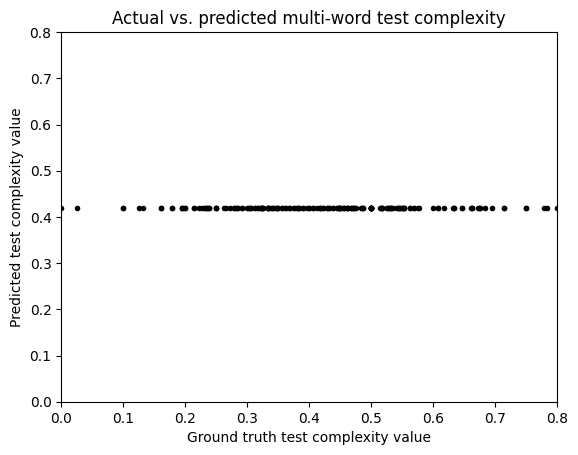

In [108]:
plt.plot(output_array_test, np.reshape(out_test_data_albert, len(out_test_data_albert)), 'k.')
plt.xlabel("Ground truth test complexity value")
plt.ylabel("Predicted test complexity value")
plt.title("Actual vs. predicted multi-word test complexity")
plt.xlim([0,0.8])
plt.ylim([0,0.8])
plt.show()

# **Ensembling**

Averaging the outputs of the three models that converged: English BERT, BERT pretrained on a medical corpus, and Electra. The first two were able to achieve lower val loss so were given 2x weight.

In [126]:
out_test_data_avg = (3*out_test_data_bert + out_test_data_bert_medical + out_test_data_electra) / 5

In [127]:
pearsonr(np.reshape(out_test_data_avg, len(out_test_data_avg)), output_array_test)

PearsonRResult(statistic=0.8076971206983636, pvalue=1.2704356379523146e-43)

In [128]:
sklearn.metrics.r2_score(output_array_test, np.reshape(out_test_data_avg, len(out_test_data_avg)))

0.6413776248167438

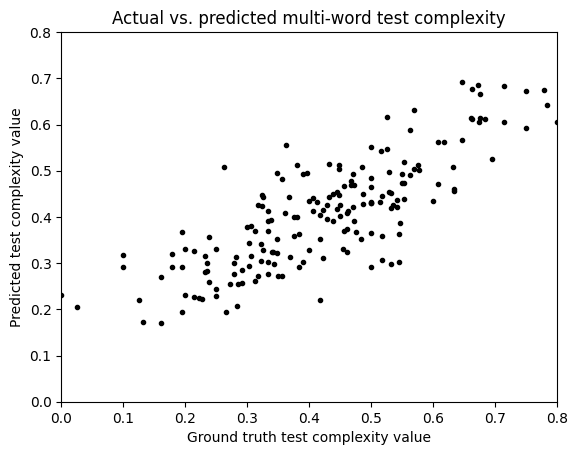

In [130]:
plt.plot(output_array_test, np.reshape(out_test_data_avg, len(out_test_data_avg)), 'k.')
plt.xlabel("Ground truth test complexity value")
plt.ylabel("Predicted test complexity value")
plt.title("Actual vs. predicted multi-word test complexity")
plt.xlim([0,0.8])
plt.ylim([0,0.8])
plt.show()

Test mean, median, std dev follow similar patterns as train data

In [131]:
print('Bible test points mean: ' + str(np.mean(np.array(output_array_test)[bible_test_idx])))
print('Biomed test points mean: ' + str(np.mean(np.array(output_array_test)[biomed_test_idx])))
print('Europarl test points mean: ' + str(np.mean(np.array(output_array_test)[europarl_test_idx])))
print('Bible test points variance: ' + str(np.var(np.array(output_array_test)[bible_test_idx])))
print('Biomed test points variance: ' + str(np.var(np.array(output_array_test)[biomed_test_idx])))
print('Europarl test points variance: ' + str(np.var(np.array(output_array_test)[europarl_test_idx])))

Bible test points mean: 0.37699347045674086
Biomed test points mean: 0.4830227348177068
Europarl test points mean: 0.4188264147945801
Bible test points variance: 0.02299753542058521
Biomed test points variance: 0.038291929220360614
Europarl test points variance: 0.008649803287904012


Pearson correlation and R2 separated by corpus. Best predictive capability on biomed sentences

In [132]:
print(pearsonr(np.reshape(out_test_data_avg[bible_test_idx], len(out_test_data_avg[bible_test_idx])), np.array(output_array_test)[bible_test_idx]))
print(pearsonr(np.reshape(out_test_data_avg[biomed_test_idx], len(out_test_data_avg[biomed_test_idx])), np.array(output_array_test)[biomed_test_idx]))
print(pearsonr(np.reshape(out_test_data_avg[europarl_test_idx], len(out_test_data_avg[europarl_test_idx])), np.array(output_array_test)[europarl_test_idx]))

PearsonRResult(statistic=0.7957328809555516, pvalue=1.428033477429368e-15)
PearsonRResult(statistic=0.8861007846255404, pvalue=1.1601434493844256e-18)
PearsonRResult(statistic=0.5087558018904431, pvalue=1.5100021056102313e-05)


In [133]:
print(sklearn.metrics.r2_score(np.array(output_array_test)[bible_test_idx], np.reshape(out_test_data_bert[bible_test_idx], len(out_test_data_bert[bible_test_idx]))))
print(sklearn.metrics.r2_score(np.array(output_array_test)[biomed_test_idx], np.reshape(out_test_data_bert[biomed_test_idx], len(out_test_data_bert[biomed_test_idx]))))
print(sklearn.metrics.r2_score(np.array(output_array_test)[europarl_test_idx], np.reshape(out_test_data_bert[europarl_test_idx], len(out_test_data_bert[europarl_test_idx]))))

0.5250508612217144
0.7305223270022247
-0.09087582662446692


Predicted values on average were between 1 and 2 points off from actuals on 5-point complexity scale (0.25 and 0.5 on 0 to 1 scale) 

In [134]:
bible_avg_abs_diff = np.mean(np.abs(np.reshape(out_test_data_bert[bible_test_idx], len(out_test_data_bert[bible_test_idx])), np.array(output_array_test)[bible_test_idx]))
biomed_avg_abs_diff = np.mean(np.abs(np.reshape(out_test_data_bert[biomed_test_idx], len(out_test_data_bert[biomed_test_idx])), np.array(output_array_test)[biomed_test_idx]))
europarl_avg_abs_diff = np.mean(np.abs(np.reshape(out_test_data_bert[europarl_test_idx], len(out_test_data_bert[europarl_test_idx])), np.array(output_array_test)[europarl_test_idx]))

print("Average absolute difference, predicted vs. actual:\n  Bible:  " + 
      str(bible_avg_abs_diff) + "\n  Biomed:  " + 
      str(biomed_avg_abs_diff) + "\n  Europarl:  " +
      str(europarl_avg_abs_diff))

Average absolute difference, predicted vs. actual:
  Bible:  0.34800317228743527
  Biomed:  0.4567010011875404
  Europarl:  0.36326860189437865


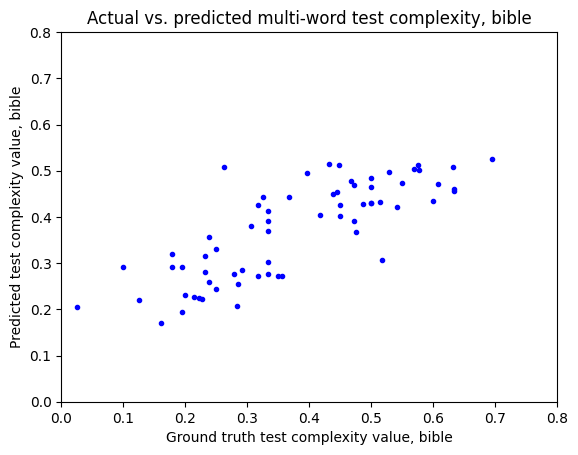

In [135]:
plt.plot(np.array(output_array_test)[bible_test_idx], np.reshape(out_test_data_avg[bible_test_idx], len(out_test_data_avg[bible_test_idx])), 'b.')
plt.xlabel("Ground truth test complexity value, bible")
plt.ylabel("Predicted test complexity value, bible")
plt.title("Actual vs. predicted multi-word test complexity, bible")
plt.xlim([0,0.8])
plt.ylim([0,0.8])
plt.show()

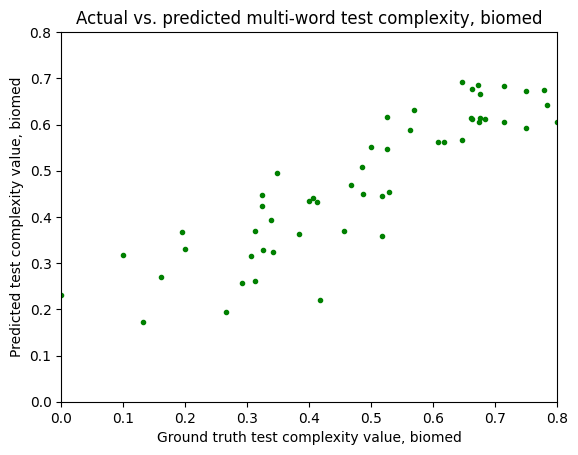

In [136]:
plt.plot(np.array(output_array_test)[biomed_test_idx], np.reshape(out_test_data_avg[biomed_test_idx], len(out_test_data_avg[biomed_test_idx])), 'g.')
plt.xlabel("Ground truth test complexity value, biomed")
plt.ylabel("Predicted test complexity value, biomed")
plt.title("Actual vs. predicted multi-word test complexity, biomed")
plt.xlim([0,0.8])
plt.ylim([0,0.8])
plt.show()


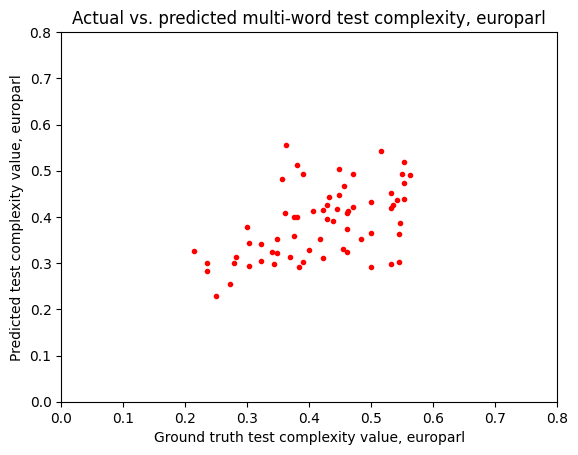

In [137]:
plt.plot(np.array(output_array_test)[europarl_test_idx], np.reshape(out_test_data_avg[europarl_test_idx], len(out_test_data_avg[europarl_test_idx])), 'r.')
plt.xlabel("Ground truth test complexity value, europarl")
plt.ylabel("Predicted test complexity value, europarl")
plt.title("Actual vs. predicted multi-word test complexity, europarl")
plt.xlim([0,0.8])
plt.ylim([0,0.8])

plt.show()